In [1]:
import tensorflow as tf
from tensorflow import keras

import pandas as pd
import numpy as np

import time
import os
from os import listdir, rmdir, remove

import matplotlib as mpl
import matplotlib.pyplot as plt

import shutil

In [2]:
mpl.rcParams['figure.figsize'] = (12, 9)

# Etude 1 - Implementing a Custom Layer that Performs Layer Normalization

The build() method should define two trainable weights α and β, both of shape input_shape[-1:] and data type tf.float32. α should be initialized with 1s, and β with 0s. The call() method should compute the mean μ and standard deviation σ of each instance’s features. For this, you can use tf.nn.moments(inputs, axes=-1, keepdims=True), which returns the mean μ and the variance σ2 of all instances (compute the square root of the variance to get the standard deviation). Then the function should compute and return α⊗(X - μ)/(σ + ε) + β, where ⊗ represents itemwise multiplication (*) and ε is a smoothing term (small constant to avoid division by zero, e.g., 0.001).

In [3]:
class MyLayerNormalization(keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)        
        
    def build(self, input_shape):
        self.alpha = self.add_weight(name="alpha", shape=input_shape[-1],
            initializer="ones", dtype=tf.float32)
        self.beta = self.add_weight(name="beta", shape=input_shape[-1],
            initializer="zeros", dtype=tf.float32)
        super().build(input_shape)
            
    def call(self, inputs, training=None):
        if training:
            mean, variance = tf.nn.moments(inputs, axes=-1, keepdims=True)
            return tf.math.multiply(self.alpha, (inputs - mean)) / (tf.math.sqrt(variance) + 0.001) + self.beta
        else:
            inputs

Ensure that your custom layer produces the same (or very nearly the same) output as the keras.layers.LayerNormalization layer.

In [4]:
test_data = tf.random.uniform([10, 5])

In [5]:
layer_norm =  MyLayerNormalization() 
layer_norm(test_data, training=True)

<tf.Tensor: shape=(10, 5), dtype=float32, numpy=
array([[ 1.5478498 , -1.0622964 ,  0.60632455, -1.0114508 , -0.08042728],
       [-0.05091065,  0.9362896 , -1.7771112 , -0.06734778,  0.95908034],
       [ 1.1403825 , -0.95806795,  1.2888482 , -0.8119683 , -0.6591943 ],
       [-0.93396765, -0.38156012, -1.0590391 ,  1.1030319 ,  1.271535  ],
       [-0.7620557 , -0.73490816,  0.6421071 ,  1.6657884 , -0.81093144],
       [-0.57665277,  1.5295482 ,  0.6940341 , -1.2962465 , -0.3506828 ],
       [ 0.17582643,  1.6267222 ,  0.15366434, -1.3944817 , -0.5617314 ],
       [-0.02725541, -1.1019223 ,  1.130667  , -1.1141512 ,  1.1126617 ],
       [ 1.1039174 ,  0.04679576, -1.8596723 ,  0.48312047,  0.22583841],
       [-0.89195675, -1.2618067 ,  1.2925439 , -0.07838422,  0.939605  ]],
      dtype=float32)>

In [6]:
layer_batch = tf.keras.layers.LayerNormalization()
layer_batch(test_data)

<tf.Tensor: shape=(10, 5), dtype=float32, numpy=
array([[ 1.513078  , -1.0384324 ,  0.59270376, -0.988729  , -0.07862055],
       [-0.05073204,  0.9330058 , -1.7708782 , -0.06711152,  0.9557166 ],
       [ 1.1393579 , -0.9572072 ,  1.2876903 , -0.8112388 , -0.65860206],
       [-0.93306553, -0.38119158, -1.0580163 ,  1.1019666 ,  1.270307  ],
       [-0.760156  , -0.7330761 ,  0.6405065 ,  1.6616359 , -0.8089099 ],
       [-0.57379234,  1.521961  ,  0.6905914 , -1.2898166 , -0.34894323],
       [ 0.17516693,  1.620621  ,  0.15308797, -1.3892515 , -0.55962455],
       [-0.02722818, -1.1008207 ,  1.1295366 , -1.1130373 ,  1.1115493 ],
       [ 1.1006138 ,  0.04665561, -1.8541073 ,  0.4816746 ,  0.22516248],
       [-0.8843485 , -1.2510436 ,  1.2815177 , -0.07771597,  0.93158954]],
      dtype=float32)>

# Etude 2 - Implementing a Custom Traning Loop

Let's train a model using a custom training loop to tackle the Fashion MNIST dataset.

In [7]:
EPOCHS_N = 25
BATCH_SIZE = 32

In [8]:
(full_X_train, full_y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

In [9]:
X_train, X_valid = full_X_train[:50000] / 255., full_X_train[50000:] / 255.

In [10]:
y_train, y_valid = full_y_train[:50000], full_y_train[50000:]

In [11]:
tf.keras.backend.set_floatx('float64')

In [12]:
inputs = keras.layers.Input(shape=(28,28))
flatten = keras.layers.Flatten()(inputs)
ln_1 = keras.layers.BatchNormalization()(flatten)
hidden_1 = keras.layers.Dense(500, activation='relu')(ln_1)
ln_2 = keras.layers.BatchNormalization()(hidden_1)
hidden_2 = keras.layers.Dense(500, activation='relu')(ln_2)
outputs = keras.layers.Dense(10, activation='softmax')(hidden_2)
model = keras.models.Model(inputs=inputs, outputs=outputs)

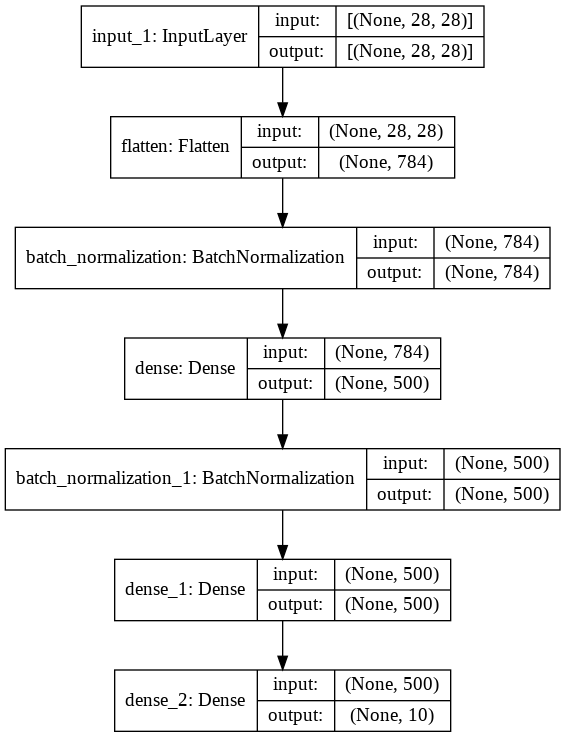

In [13]:
keras.utils.plot_model(model, show_shapes=True)

In [14]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="Nadam",
              metrics=["accuracy"])

In [15]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

In [16]:
history = model.fit(X_train, y_train, epochs=EPOCHS_N, validation_data=(X_valid, y_valid), callbacks=[early_stopping_cb])

Epoch 1/25
1563/1563 [==============================] - 20s 12ms/step - loss: 0.2262 - accuracy: 0.9308 - val_loss: 0.1361 - val_accuracy: 0.9608
Epoch 2/25
1563/1563 [==============================] - 18s 12ms/step - loss: 0.1100 - accuracy: 0.9660 - val_loss: 0.1233 - val_accuracy: 0.9666
Epoch 3/25
1563/1563 [==============================] - 18s 11ms/step - loss: 0.0830 - accuracy: 0.9738 - val_loss: 0.1149 - val_accuracy: 0.9716
Epoch 4/25
1563/1563 [==============================] - 18s 11ms/step - loss: 0.0644 - accuracy: 0.9790 - val_loss: 0.1066 - val_accuracy: 0.9737
Epoch 5/25
1563/1563 [==============================] - 17s 11ms/step - loss: 0.0562 - accuracy: 0.9820 - val_loss: 0.1283 - val_accuracy: 0.9705
Epoch 6/25
1563/1563 [==============================] - 18s 11ms/step - loss: 0.0477 - accuracy: 0.9845 - val_loss: 0.1049 - val_accuracy: 0.9787
Epoch 7/25
1563/1563 [==============================] - 17s 11ms/step - loss: 0.0458 - accuracy: 0.9859 - val_loss: 0.0972 -

In [17]:
model.evaluate(X_test, y_test, verbose=2)

313/313 - 1s - loss: 274.7415 - accuracy: 0.8395


[274.74147551279066, 0.8395]

Display the epoch, iteration, mean training loss, and mean accuracy over each epoch (updated at each iteration), as well as the validation loss and accuracy at the end of each epoch.

In [18]:
n_steps = len(X_train) // BATCH_SIZE
optimizer = keras.optimizers.Nadam()
loss_fn = keras.losses.sparse_categorical_crossentropy
mean_loss = keras.metrics.Mean()
mean_accuracy = keras.metrics.Mean()
metric = keras.metrics.SparseCategoricalAccuracy()

In [19]:
def random_batch(X, y, batch_size=32):
    idx = np.random.randint(len(X), size=batch_size)
    return X[idx], y[idx]

In [20]:
for epoch in range(1, EPOCHS_N + 1):
    print(f"Epoch {epoch} / {EPOCHS_N}")
    for step in range(1, n_steps + 1):
        X_batch, y_batch = random_batch(X_train, y_train)
        with tf.GradientTape() as tape:
            y_pred = model(X_batch)
            loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
            accuracy = tf.reduce_mean(metric(y_batch, y_pred))
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        mean_loss(loss)               
        mean_accuracy(accuracy)        

    y_pred_valid = model(X_valid)
    val_loss = tf.reduce_mean(loss_fn(y_valid, y_pred_valid))

    print(f" Mean accuracy: {mean_accuracy(accuracy)}")
    print(f" Mean training loss: {mean_loss(loss)}")
    print(f" Validation loss: {val_loss}")
    print(f" Validation accuracy: {model.evaluate(X_valid, y_valid, verbose=0)[1]}")
    metric.reset_states()        

Epoch 1 / 25
 Mean accuracy: 0.9917815193146625
 Mean training loss: 0.033395678626618554
 Validation loss: 0.11030758720197562
 Validation accuracy: 0.9789
Epoch 2 / 25
 Mean accuracy: 0.9922441247672297
 Mean training loss: 0.02958556157196091
 Validation loss: 0.13540940269738813
 Validation accuracy: 0.9741
Epoch 3 / 25
 Mean accuracy: 0.9926298267544058
 Mean training loss: 0.026291712986990384
 Validation loss: 0.16031381083114735
 Validation accuracy: 0.9746
Epoch 4 / 25
 Mean accuracy: 0.9929232672899981
 Mean training loss: 0.024949346064413895
 Validation loss: 0.15616320820978868
 Validation accuracy: 0.9785
Epoch 5 / 25
 Mean accuracy: 0.9933542034938665
 Mean training loss: 0.023742484799439984
 Validation loss: 0.18019473217235807
 Validation accuracy: 0.9737
Epoch 6 / 25
 Mean accuracy: 0.9934629323361494
 Mean training loss: 0.023073215666145095
 Validation loss: 0.16293036091342014
 Validation accuracy: 0.977
Epoch 7 / 25
 Mean accuracy: 0.99386731875769
 Mean training

Try using a different optimizer with a different learning rate for the upper layers and the lower layers.

In [21]:
keras.backend.clear_session()

In [22]:
# we should use flatten(); otherwise, we get list of lists
# we use condition because some layers have not trainable variables
lower_layers_params = tf.nest.flatten([layer.trainable_variables for layer in model.layers[:4] if layer.trainable_variables])
upper_layers_params = tf.nest.flatten([layer.trainable_variables for layer in model.layers[4:] if layer.trainable_variables])

In [23]:
optimizer1 = keras.optimizers.Nadam(learning_rate=0.00001)
optimizer2 = keras.optimizers.Nadam(learning_rate=0.0001)

In [24]:
for epoch in range(1, EPOCHS_N + 1):
    print(f"Epoch {epoch} / {EPOCHS_N}")
    for step in range(1, n_steps + 1):
        X_batch, y_batch = random_batch(X_train, y_train)
        with tf.GradientTape() as tape:
            y_pred = model(X_batch)
            loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
            accuracy = tf.reduce_mean(metric(y_batch, y_pred))
        
        gradients = tape.gradient(loss, lower_layers_params + upper_layers_params)
                
        # here we split the gradients into lower and upper layer params
        gradients1 = gradients[:len(lower_layers_params)]
        gradients2 = gradients[len(lower_layers_params):]
        
        # apply own optimizer to each layer
        optimizer1.apply_gradients(zip(gradients1, lower_layers_params))
        optimizer2.apply_gradients(zip(gradients2, upper_layers_params))       
        
        mean_loss(loss)               
        mean_accuracy(accuracy)        

    y_pred_valid = model(X_valid)
    val_loss = tf.reduce_mean(loss_fn(y_valid, y_pred_valid))

    print(f" Mean accuracy: {mean_accuracy(accuracy)}")
    print(f" Mean training loss: {mean_loss(loss)}")
    print(f" Validation loss: {val_loss}")
    print(f" Validation accuracy: {model.evaluate(X_valid, y_valid, verbose=0)[1]}")
    metric.reset_states()

Epoch 1 / 25
 Mean accuracy: 0.9960565866835004
 Mean training loss: 0.01650127143391803
 Validation loss: 0.24061160681759874
 Validation accuracy: 0.9824
Epoch 2 / 25
 Mean accuracy: 0.9961902358401494
 Mean training loss: 0.015942502364860427
 Validation loss: 0.23872527062914142
 Validation accuracy: 0.983
Epoch 3 / 25
 Mean accuracy: 0.9963182363877943
 Mean training loss: 0.015395242840420983
 Validation loss: 0.2368163996345993
 Validation accuracy: 0.9832
Epoch 4 / 25
 Mean accuracy: 0.9964377310303355
 Mean training loss: 0.014877632135965666
 Validation loss: 0.23562260022000547
 Validation accuracy: 0.9834
Epoch 5 / 25
 Mean accuracy: 0.9965564733293243
 Mean training loss: 0.014382832732802255
 Validation loss: 0.2357102606050392
 Validation accuracy: 0.9834
Epoch 6 / 25
 Mean accuracy: 0.9966675548348299
 Mean training loss: 0.013919478084861223
 Validation loss: 0.23625714979678028
 Validation accuracy: 0.9835
Epoch 7 / 25
 Mean accuracy: 0.9967716937462415
 Mean training

In [25]:
model.evaluate(X_test, y_test, verbose=2)

313/313 - 1s - loss: 676.8598 - accuracy: 0.9372


[676.85975329479, 0.9372]